In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from lora_utils import AdaLoRALinear, RankAllocator, compute_adalora_orth_regu

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

def generate_dataset(n_samples=1000):
    # Generate spiral dataset
    def generate_spiral(n_samples, noise=0.5):
        n = np.sqrt(np.random.rand(n_samples,1)) * 780 * (2*np.pi)/360.0
        d1x = -np.cos(n)*n + np.random.rand(n_samples,1) * noise
        d1y = np.sin(n)*n + np.random.rand(n_samples,1) * noise
        return np.hstack((d1x,d1y))

    # Generate data for two classes
    X1 = generate_spiral(n_samples//2)
    X2 = generate_spiral(n_samples//2) + np.array([5, 5])
    X = np.vstack([X1, X2])

    # Create labels
    y = np.hstack([np.zeros(n_samples//2), np.ones(n_samples//2)])

    # Convert to torch tensors
    X = torch.FloatTensor(X)
    y = torch.LongTensor(y)

    return X, y

# Base Model Definition
class BaseModel(nn.Module):
    def __init__(self, input_dim=2, hidden_dims=[64, 32, 16], output_dim=2):
        super().__init__()

        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim)
            ])
            prev_dim = hidden_dim

        layers.append(nn.Linear(prev_dim, output_dim))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# AdaLoRA Model Definition
class AdaLoRAModel(nn.Module):
    def __init__(self, input_dim=2, hidden_dims=[64, 32, 16], output_dim=2, r=8):
        super().__init__()

        layers = []
        prev_dim = input_dim

        for hidden_dim in hidden_dims:
            layers.extend([
                AdaLoRALinear(prev_dim, hidden_dim, r=r),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim)
            ])
            prev_dim = hidden_dim

        layers.append(AdaLoRALinear(prev_dim, output_dim, r=r))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

def train_base_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses = []
    val_losses = []
    val_accuracies = []

    print("Training Base Model:")
    for epoch in range(epochs):
        # Training
        model.train()
        epoch_loss = 0
        for X, y in train_loader:
            optimizer.zero_grad()
            outputs = model(X)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        train_losses.append(epoch_loss/len(train_loader))

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in val_loader:
                outputs = model(X)
                loss = criterion(outputs, y)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                total += y.size(0)
                correct += predicted.eq(y).sum().item()

        val_losses.append(val_loss/len(val_loader))
        val_accuracies.append(100.*correct/total)

        print(f'Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, '
              f'Val Loss={val_losses[-1]:.4f}, Val Acc={val_accuracies[-1]:.2f}%')

    return train_losses, val_losses, val_accuracies

def train_adalora(model, train_loader, val_loader, criterion, epochs=10):
    # Initialize RankAllocator
    allocator = RankAllocator(
        model=model,
        lora_r=8,
        target_rank=4,
        init_warmup=2,
        final_warmup=2,
        mask_interval=1,
        total_step=epochs * len(train_loader)
    )

    optimizer = optim.Adam(model.parameters())
    train_losses = []
    val_losses = []
    val_accuracies = []
    global_step = 0

    print("\nTraining AdaLoRA Model:")
    for epoch in range(epochs):
        # Training
        model.train()
        epoch_loss = 0
        for X, y in train_loader:
            optimizer.zero_grad()
            outputs = model(X)

            # Compute main loss
            task_loss = criterion(outputs, y)

            # Add orthogonal regularization
            orth_loss = compute_adalora_orth_regu(model)
            loss = task_loss + orth_loss

            loss.backward()
            optimizer.step()

            # Update ranks
            curr_rank, threshold = allocator.update_and_mask(model, global_step)

            epoch_loss += loss.item()
            global_step += 1

        train_losses.append(epoch_loss/len(train_loader))

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for X, y in val_loader:
                outputs = model(X)
                loss = criterion(outputs, y)
                val_loss += loss.item()

                _, predicted = outputs.max(1)
                total += y.size(0)
                correct += predicted.eq(y).sum().item()

        val_losses.append(val_loss/len(val_loader))
        val_accuracies.append(100.*correct/total)

        print(f'Epoch {epoch+1}: Train Loss={train_losses[-1]:.4f}, '
              f'Val Loss={val_losses[-1]:.4f}, Val Acc={val_accuracies[-1]:.2f}%, '
              f'Curr Rank={curr_rank}')

    return train_losses, val_losses, val_accuracies

def plot_results(base_results, adalora_results):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot training losses
    axes[0].plot(base_results[0], label='Base Model')
    axes[0].plot(adalora_results[0], label='AdaLoRA')
    axes[0].set_title('Training Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    # Plot validation losses
    axes[1].plot(base_results[1], label='Base Model')
    axes[1].plot(adalora_results[1], label='AdaLoRA')
    axes[1].set_title('Validation Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()

    # Plot validation accuracies
    axes[2].plot(base_results[2], label='Base Model')
    axes[2].plot(adalora_results[2], label='AdaLoRA')
    axes[2].set_title('Validation Accuracy')
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Accuracy (%)')
    axes[2].legend()

    plt.tight_layout()
    plt.show()


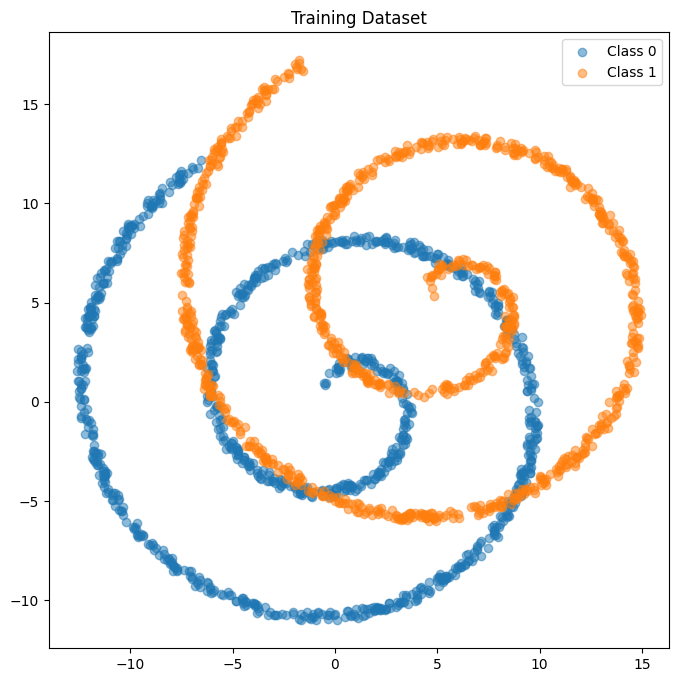

In [2]:

# Generate datasets
X_train, y_train = generate_dataset(2000)
X_val, y_val = generate_dataset(500)

# Create data loaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Plot dataset
plt.figure(figsize=(8, 8))
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], alpha=0.5, label='Class 0')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], alpha=0.5, label='Class 1')
plt.legend()
plt.title('Training Dataset')
plt.show()



Training Base Model:
Epoch 1: Train Loss=0.5447, Val Loss=0.4654, Val Acc=75.40%
Epoch 2: Train Loss=0.4689, Val Loss=0.3943, Val Acc=82.20%
Epoch 3: Train Loss=0.4320, Val Loss=0.3682, Val Acc=83.60%
Epoch 4: Train Loss=0.4213, Val Loss=0.3324, Val Acc=82.40%
Epoch 5: Train Loss=0.4044, Val Loss=0.3122, Val Acc=87.00%
Epoch 6: Train Loss=0.4097, Val Loss=0.3232, Val Acc=86.40%
Epoch 7: Train Loss=0.3761, Val Loss=0.2972, Val Acc=90.80%
Epoch 8: Train Loss=0.3895, Val Loss=0.2863, Val Acc=90.20%
Epoch 9: Train Loss=0.3677, Val Loss=0.2919, Val Acc=85.60%
Epoch 10: Train Loss=0.3769, Val Loss=0.2801, Val Acc=87.80%

Training AdaLoRA Model:
Epoch 1: Train Loss=1.0334, Val Loss=0.6846, Val Acc=50.80%, Curr Rank=27
Epoch 2: Train Loss=0.8177, Val Loss=0.6052, Val Acc=62.20%, Curr Rank=24
Epoch 3: Train Loss=0.6836, Val Loss=0.5428, Val Acc=68.80%, Curr Rank=21
Epoch 4: Train Loss=0.6170, Val Loss=0.5097, Val Acc=75.00%, Curr Rank=19
Epoch 5: Train Loss=0.5926, Val Loss=0.4884, Val Acc=76.6

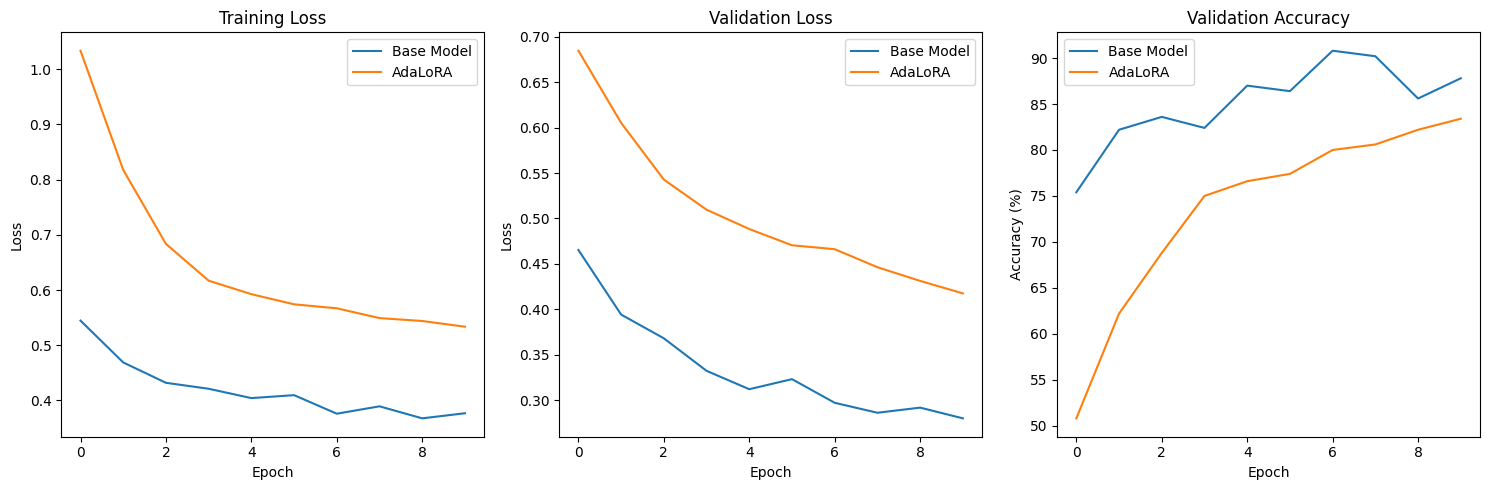

In [4]:
# Initialize and train base model
base_model = BaseModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(base_model.parameters())
base_results = train_base_model(base_model, train_loader, val_loader, criterion, optimizer)

# Create and initialize AdaLoRA model
adalora_model = AdaLoRAModel()

# Copy weights from base model to AdaLoRA model
with torch.no_grad():
    for (name1, param1), (name2, param2) in zip(
        base_model.named_parameters(),
        adalora_model.named_parameters()
    ):
        if 'weight' in name1 and 'lora' not in name2:
            param2.data.copy_(param2.data)
        elif 'bias' in name1:
            param2.data.copy_(param2.data)

# Train with AdaLoRA
adalora_results = train_adalora(adalora_model, train_loader, val_loader, criterion)

# Plot comparison results
plot_results(base_results, adalora_results)


In [26]:
# Create and initialize AdaLoRA model
adalora_model = AdaLoRAModel()

# First, let's create mappings of parameters
base_params = {}
adalora_params = {}

print("\nMapping parameters:")
for name, param in base_model.named_parameters():
    print(f"Base: {name}")
    layer_num = name.split('.')[1]  # Get layer number
    if layer_num not in base_params:
        base_params[layer_num] = {}
    base_params[layer_num][name] = param

for name, param in adalora_model.named_parameters():
    print(f"AdaLoRA: {name}")
    layer_num = name.split('.')[1]  # Get layer number
    if layer_num not in adalora_params:
        adalora_params[layer_num] = {}
    adalora_params[layer_num][name] = param



Mapping parameters:
Base: model.0.weight
Base: model.0.bias
Base: model.2.weight
Base: model.2.bias
Base: model.3.weight
Base: model.3.bias
Base: model.5.weight
Base: model.5.bias
Base: model.6.weight
Base: model.6.bias
Base: model.8.weight
Base: model.8.bias
Base: model.9.weight
Base: model.9.bias
AdaLoRA: model.0.weight
AdaLoRA: model.0.bias
AdaLoRA: model.0.lora_A
AdaLoRA: model.0.lora_E
AdaLoRA: model.0.lora_B
AdaLoRA: model.0.ranknum
AdaLoRA: model.2.weight
AdaLoRA: model.2.bias
AdaLoRA: model.3.weight
AdaLoRA: model.3.bias
AdaLoRA: model.3.lora_A
AdaLoRA: model.3.lora_E
AdaLoRA: model.3.lora_B
AdaLoRA: model.3.ranknum
AdaLoRA: model.5.weight
AdaLoRA: model.5.bias
AdaLoRA: model.6.weight
AdaLoRA: model.6.bias
AdaLoRA: model.6.lora_A
AdaLoRA: model.6.lora_E
AdaLoRA: model.6.lora_B
AdaLoRA: model.6.ranknum
AdaLoRA: model.8.weight
AdaLoRA: model.8.bias
AdaLoRA: model.9.weight
AdaLoRA: model.9.bias
AdaLoRA: model.9.lora_A
AdaLoRA: model.9.lora_E
AdaLoRA: model.9.lora_B
AdaLoRA: model

In [31]:
adalora_params

dict_keys(['0', '2', '3', '5', '6', '8', '9'])

In [32]:
# Copy and combine weights
with torch.no_grad():
    for base_layer_num in ['0', '3', '6', '9']:  # Layer numbers in base model
        adalora_layer_num = base_layer_num

        if len(adalora_params[adalora_layer_num]) == 2:  # Regular layer
            # Copy weight and bias directly
            for name, param in base_params[base_layer_num].items():
                if 'weight' in name:
                    adalora_params[adalora_layer_num][f'model.{adalora_layer_num}.weight'].data.copy_(param.data)
                elif 'bias' in name:
                    adalora_params[adalora_layer_num][f'model.{adalora_layer_num}.bias'].data.copy_(param.data)

        else:  # LoRA layer
            # Get base weight and bias
            base_weight = base_params[base_layer_num][f'model.{base_layer_num}.weight']
            base_bias = base_params[base_layer_num][f'model.{base_layer_num}.bias']

            # Get LoRA parameters
            lora_dict = adalora_params[adalora_layer_num]
            lora_A = lora_dict[f'model.{adalora_layer_num}.lora_A']
            lora_B = lora_dict[f'model.{adalora_layer_num}.lora_B']
            lora_E = lora_dict[f'model.{adalora_layer_num}.lora_E']
            ranknum = lora_dict[f'model.{adalora_layer_num}.ranknum']

            # Combine weights

            combined_weight = base_weight + (lora_B @ (lora_A * lora_E)) * ranknum

            # Copy combined weight and bias
            adalora_params[adalora_layer_num][f'model.{adalora_layer_num}.weight'].data.copy_(combined_weight.data)
            adalora_params[adalora_layer_num][f'model.{adalora_layer_num}.bias'].data.copy_(base_bias.data)

print("Weight transfer completed!")


Weight transfer completed!


In [40]:
base_params["0"][f'model.{0}.weight']

Parameter containing:
tensor([[ 0.4797,  0.5428],
        [-0.2277,  0.1339],
        [-0.6646, -0.4832],
        [-0.1066, -0.2655],
        [-0.3049,  0.6075],
        [ 0.3783,  0.0752],
        [-0.1360, -0.0231],
        [ 0.5339, -0.1503],
        [ 0.0654,  0.2304],
        [ 0.4374,  0.4126],
        [-0.3117,  0.2987],
        [ 0.1522,  0.0685],
        [-0.6146,  0.6503],
        [ 0.2977,  0.0791],
        [ 0.2742, -0.1860],
        [-0.5021, -0.1940],
        [-0.5837,  0.6593],
        [ 0.2967,  0.1956],
        [-0.4411, -0.4920],
        [ 0.3677, -0.6096],
        [ 0.1262,  0.5587],
        [-0.5933,  0.5234],
        [-0.5940, -0.1161],
        [ 0.5363,  0.4761],
        [ 0.6718,  0.5563],
        [-0.6847,  0.1353],
        [-0.5976,  0.4193],
        [ 0.1888,  0.5712],
        [ 0.1758,  0.4775],
        [-0.0362, -0.6251],
        [-0.4672, -0.0370],
        [-0.6053,  0.6321],
        [-0.3775, -0.5826],
        [ 0.6807, -0.4581],
        [-0.2877,  0.0550]

In [47]:
adalora_params.keys()

dict_keys(['0', '2', '3', '5', '6', '8', '9'])

In [49]:
# Copy and combine weights
with torch.no_grad():
    for base_layer_num in list(adalora_params.keys()):  # Layer numbers in base model
        adalora_layer_num = base_layer_num

        if len(adalora_params[adalora_layer_num]) == 2:  # Regular layer
            # Copy weight and bias directly
            for name, param in base_params[base_layer_num].items():
                if 'weight' in name:
                    adalora_params[adalora_layer_num][f'model.{adalora_layer_num}.weight'].data.copy_(param.data)
                elif 'bias' in name:
                    adalora_params[adalora_layer_num][f'model.{adalora_layer_num}.bias'].data.copy_(param.data)

        else:  # LoRA layer
            # Get base weight and bias
            print(base_layer_num)
            base_weight = base_params[base_layer_num][f'model.{base_layer_num}.weight']
            base_bias = base_params[base_layer_num][f'model.{base_layer_num}.bias']

            # Get LoRA parameters
            lora_dict = adalora_params[adalora_layer_num]
            lora_A = lora_dict[f'model.{adalora_layer_num}.lora_A']
            lora_B = lora_dict[f'model.{adalora_layer_num}.lora_B']
            lora_E = lora_dict[f'model.{adalora_layer_num}.lora_E']
            ranknum = lora_dict[f'model.{adalora_layer_num}.ranknum']

            # Combine weights

            combined_weight = base_weight + (lora_B @ (lora_A * lora_E)) * ranknum

            # Copy combined weight and bias
            adalora_params[adalora_layer_num][f'model.{adalora_layer_num}.weight'].data.copy_(combined_weight.data)
            adalora_params[adalora_layer_num][f'model.{adalora_layer_num}.bias'].data.copy_(base_bias.data)

print("Weight transfer completed!")


0
3
6
9
Weight transfer completed!



Training AdaLoRA Model:
Epoch 1: Train Loss=1.5495, Val Loss=0.7971, Val Acc=73.40%, Curr Rank=27
Epoch 2: Train Loss=0.9820, Val Loss=0.4474, Val Acc=75.80%, Curr Rank=24
Epoch 3: Train Loss=0.7109, Val Loss=0.3825, Val Acc=76.80%, Curr Rank=21
Epoch 4: Train Loss=0.5991, Val Loss=0.3564, Val Acc=81.20%, Curr Rank=19
Epoch 5: Train Loss=0.6085, Val Loss=0.3428, Val Acc=83.40%, Curr Rank=18
Epoch 6: Train Loss=0.5484, Val Loss=0.3252, Val Acc=83.40%, Curr Rank=17
Epoch 7: Train Loss=0.5460, Val Loss=0.3138, Val Acc=84.60%, Curr Rank=16
Epoch 8: Train Loss=0.5513, Val Loss=0.3145, Val Acc=85.60%, Curr Rank=16
Epoch 9: Train Loss=0.5593, Val Loss=0.2844, Val Acc=88.20%, Curr Rank=16
Epoch 10: Train Loss=0.5220, Val Loss=0.2799, Val Acc=87.40%, Curr Rank=16


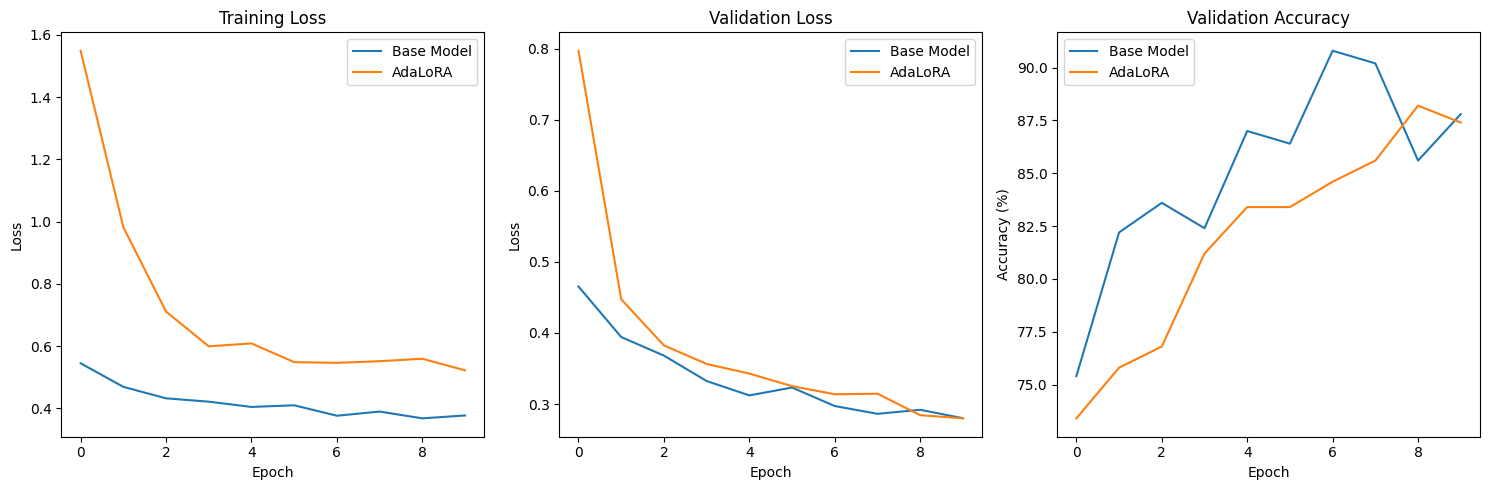

In [50]:
adalora_results = train_adalora(adalora_model, train_loader, val_loader, criterion)

# Plot comparison results
plot_results(base_results, adalora_results)

In [12]:
list(adalora_params["0"].keys())

['model.0.weight',
 'model.0.bias',
 'model.0.lora_A',
 'model.0.lora_E',
 'model.0.lora_B',
 'model.0.ranknum']

In [21]:
adalora_params["3"].keys()

dict_keys(['model.3.weight', 'model.3.bias', 'model.3.lora_A', 'model.3.lora_E', 'model.3.lora_B', 'model.3.ranknum'])

In [ ]:
base_model

BaseModel(
  (model): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [ ]:
adalora_model

AdaLoRAModel(
  (model): Sequential(
    (0): AdaLoRALinear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): AdaLoRALinear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): AdaLoRALinear(in_features=32, out_features=16, bias=True)
    (7): ReLU()
    (8): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): AdaLoRALinear(in_features=16, out_features=2, bias=True)
  )
)